# In this Radio Astronomy Pulsar Practicum you will analyse data from the pulsar B0355+54. 

Please fill in this Jupyter Notebook with the code to produce the plots and answer the questions. 
The total assignment is worth 10 points (+1 bonus point). 
Some of the necessary code has been kept to help you start the project and help you along. 

First, we import the necessary python modules.

In [1]:
%matplotlib inline
from matplotlib.pyplot import figure, show
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import chisquare
import scipy.optimize as opt
from scipy import fft, ifft
import math
import scipy


Now, we will load the data into a numpy array to make it easier to work with.

This data was taken with the 100-m Effelsberg telescope using the PSRIX pulsar backend.

Note: the data is
    (a) B0355+54_dynamicspectrum.npy is a numpy array of the dynamic spectrum with shape (number of frequency bins, number of time bins).
    (b) B0355+54_headerinfo.npy contains a dictionary of the header information. This information can be used to convert from bins to physical units e.g. seconds.

In [2]:
path = '/Users/Zizi/RadioAstronomy/pulsar_practicum_data-1/'

In [3]:
ds=np.load(path + 'B0355+54_dynamicspectrum.npy')
#print shape of dynamic spectrum
print("DS shape is: "+str(ds.shape))


header={'telescope_id': 8, 'rawdatafile': 'FILENAME0', 'source_name': 'B0355+54', 'data_type': 1, 'nchans': 512, 'ibeam': 0, 'nifs': 1, 'tsamp': 0.00010240000000000002, 'foff': -0.48828125, 'src_raj': 35853.7, 'src_dej': 541314.0, 'tstart': 59265.91620925926, 'az_start': 0.0, 'fch1': 1505.4375, 'nbeams': 0, 'machine_id': 11, 'za_start': 0.0, 'nbits': 32}
#print the header information
print(header)

DS shape is: (512, 10000)
{'telescope_id': 8, 'rawdatafile': 'FILENAME0', 'source_name': 'B0355+54', 'data_type': 1, 'nchans': 512, 'ibeam': 0, 'nifs': 1, 'tsamp': 0.00010240000000000002, 'foff': -0.48828125, 'src_raj': 35853.7, 'src_dej': 541314.0, 'tstart': 59265.91620925926, 'az_start': 0.0, 'fch1': 1505.4375, 'nbeams': 0, 'machine_id': 11, 'za_start': 0.0, 'nbits': 32}


The first axis of the dynamic spectrum is the frequency axis, and the second axis is the time axis. At the moment this is in bins (i.e. dimensionless units). 

Problem 1 : Create frequency and time axes (in MHz and seconds) using the header information above.

Question 1: What is the total duration (in seconds) of this data?

In [4]:
ds =ds[::-1]  #flipping frequency axis of the 2D matrix
cmap_c = 'bone'

In [5]:
tsamp = header['tsamp'] # sampling time in seconds
fch1 = header['fch1'] # frequency of channel 1 in MHz
# Note that this frequency is the middle of the top frequency channel
foff = header['foff'] # channel width in MHz
# Note the negative sign implies the band is flipped 
# (i.e. the higher frequencies are at the bottom)
# Tip: best here to flip the frequency axis in ds 
# and create the frequency array from low frequencies to high.

time = np.zeros(10000)             #creating the time axis
f = np.zeros(512)                  #creatinf the frequency axis
f[0] = 1505.4375 

for i in range(10000-1):
    time[i+1] = time[i]+tsamp
    
for i in range(512-1):
    f[i+1] = f[i] +foff
    
f = np.flip(f)                 #flipping the frequency as suggested
print("The total duration of the data is {:.3f} seconds".format(time[-1]))

The total duration of the data is 1.024 seconds


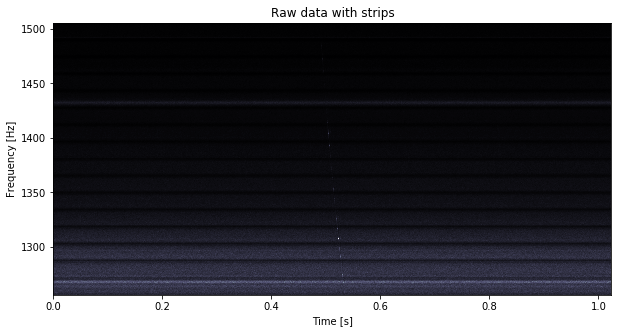

In [6]:
#plotting the raw data to get an idea

fig = figure(figsize=(10,5))
frame = fig.add_subplot(1,1,1)

frame.imshow(ds,aspect = 'auto', origin='lower', cmap=cmap_c, extent = [0,time[-1], f[0],f[-1]])
frame.set_title("Raw data with strips")
frame.set_xlabel("Time [s]")
frame.set_ylabel("Frequency [Hz]")

show()

Now plot the dynamic spectrum of the data. 

Question 2: Why does the data appear striped?

Problem 2: Correct the data for this stripy pattern. Plot the dynamic spectrum after correcting for this. 

Hint: it might be helpful to scale each channel independently in the colour map to more clearly see the pulse.

Problem/Question 1 and 2 together are worth 1 point.

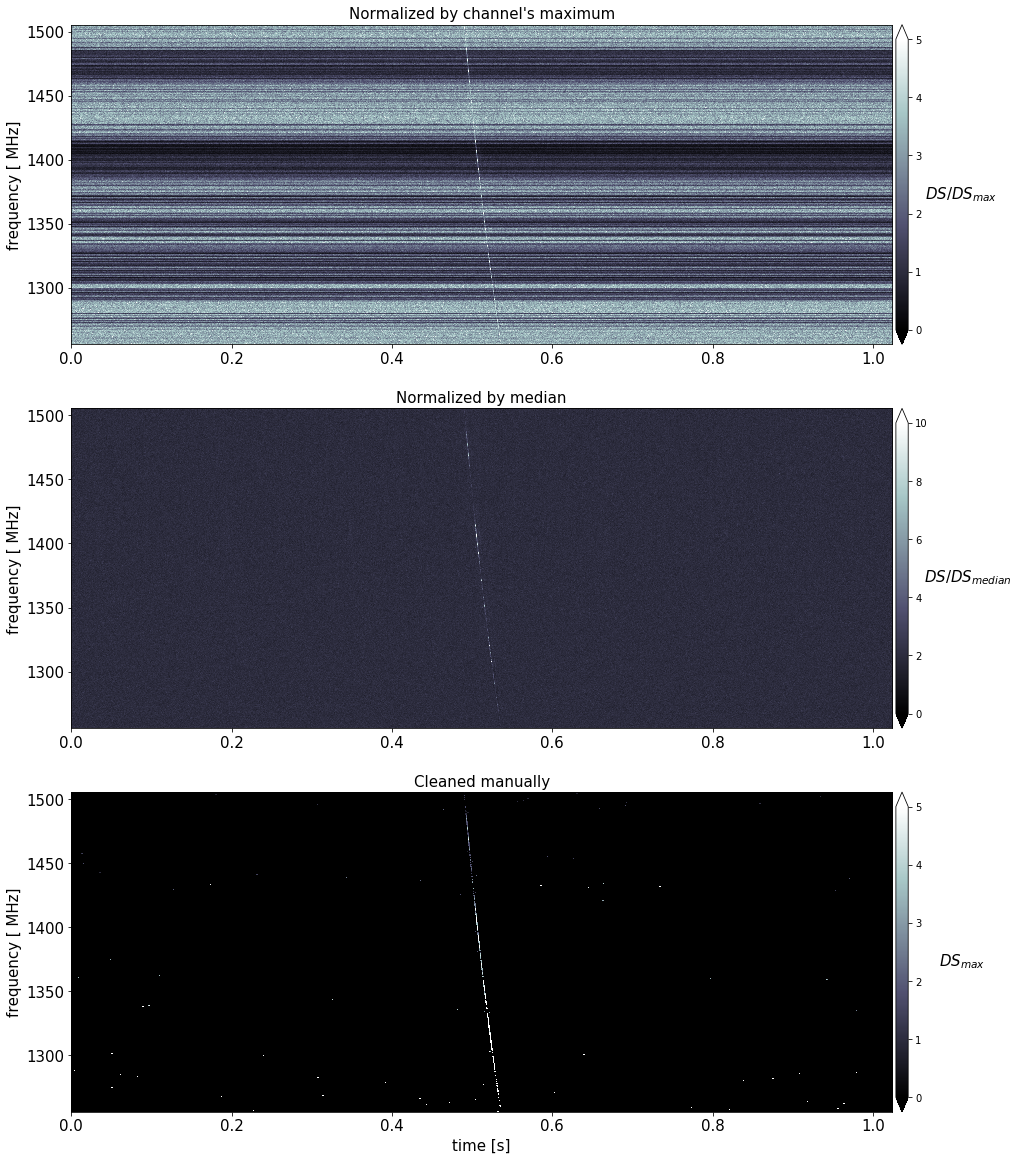

In [7]:
fig = figure(figsize=(15,20))
frame0 = fig.add_subplot(3,1,1)
frame1 = fig.add_subplot(3,1,2,sharex=frame0)
frame2 = fig.add_subplot(3,1,3, sharex=frame1)

ds_n = ds.copy()
ds_N = ds.copy()

ds_normal = np.zeros((np.shape(ds)[0], np.shape(ds)[1]))    #to store normalized DS by its median
fs=15                 #fontsize

for i in range(np.shape(ds)[0]):                           #normalizing by maximum value
    ds_N[i,:]=ds_N[i,:]/ds_N[i,:].max()

for i in range(np.shape(ds)[0]):         #clean the data manually, only keep the peak, and zero the rest
    imax = np.argmax(ds_n[i,:])

    ds_n[i,:][:imax-8]=np.zeros_like(ds_n[i,:][:imax-8])
    imax = np.argmax(ds_n[i,:])
    ds_n[i,:][imax+8:]=np.zeros_like(ds_n[i,:][imax+8:])
    
for i in range(np.shape(ds)[0]):        #clean by dividing the data by its median
    
    ds_normal[i,:] = ds[i,:]/np.median(ds[i,:])   
    
zero = frame0.imshow(ds_N,aspect = 'auto', origin='lower', cmap=cmap_c, extent = [0,time[-1], f[0],f[-1]])
a = frame1.imshow(ds_normal,aspect = 'auto', origin='lower', cmap=cmap_c, extent = [0,time[-1], f[0],f[-1]],vmin=0,vmax=5)
b = frame2.imshow(ds_n,aspect = 'auto', origin='lower', cmap=cmap_c, extent = [0,time[-1], f[0],f[-1]],vmin=0,vmax=10)

frame2.set_xlabel("time [s]", fontsize=(fs))
frame2.set_ylabel('frequency [ MHz]', fontsize= fs)
frame1.set_ylabel('frequency [ MHz]', fontsize= fs)
frame0.set_ylabel('frequency [ MHz]', fontsize= fs)


divider0 = make_axes_locatable(frame0)

cax0 = divider0.append_axes("right", size="1.5%", pad=0.05)
cbar0 = plt.colorbar(a, cax=cax0, extend='both')
cbar0.set_label(r'$DS/DS_{max}$', rotation=0,labelpad=40, fontsize =fs)

divider = make_axes_locatable(frame2)

cax = divider.append_axes("right", size="1.5%", pad=0.05)
cbar = plt.colorbar(a, cax=cax, extend='both')
cbar.set_label(r'$DS_{max}$', rotation=0,labelpad=40, fontsize =fs)

divider1 = make_axes_locatable(frame1)
cax1 = divider1.append_axes("right", size="1.5%", pad=0.05)
cbar1 = plt.colorbar(b, cax=cax1, extend='both')
cbar1.set_label(r'$DS/DS_{median}$', rotation=0,labelpad=40, fontsize =fs)


frame2.tick_params(axis='both', which='major', labelsize=fs)
frame1.tick_params(axis='both', which='major', labelsize=fs)
frame0.tick_params(axis='both', which='major', labelsize=fs)

frame0.set_title("Normalized by channel's maximum",fontsize =fs)
frame2.set_title("Cleaned manually",fontsize =fs)
frame1.set_title("Normalized by median",fontsize =fs)

plt.subplots_adjust(wspace =0.2,hspace=0.2)

show()

#### In order to explain the strips we can take a look at the data in two aspects: 1. we look at the flux density S for a few frequencies versus time, 2. we take a look at the variation of frequencies for a few time instances

In [8]:
from scipy.ndimage import gaussian_filter

In [9]:
ds=np.load(path + 'B0355+54_dynamicspectrum.npy')
#print shape of dynamic spectrum
print("DS shape is: "+str(ds.shape))
ds =ds[::-1]  #flipping frequency axis


DS shape is: (512, 10000)


DS shape is: (512, 10000)


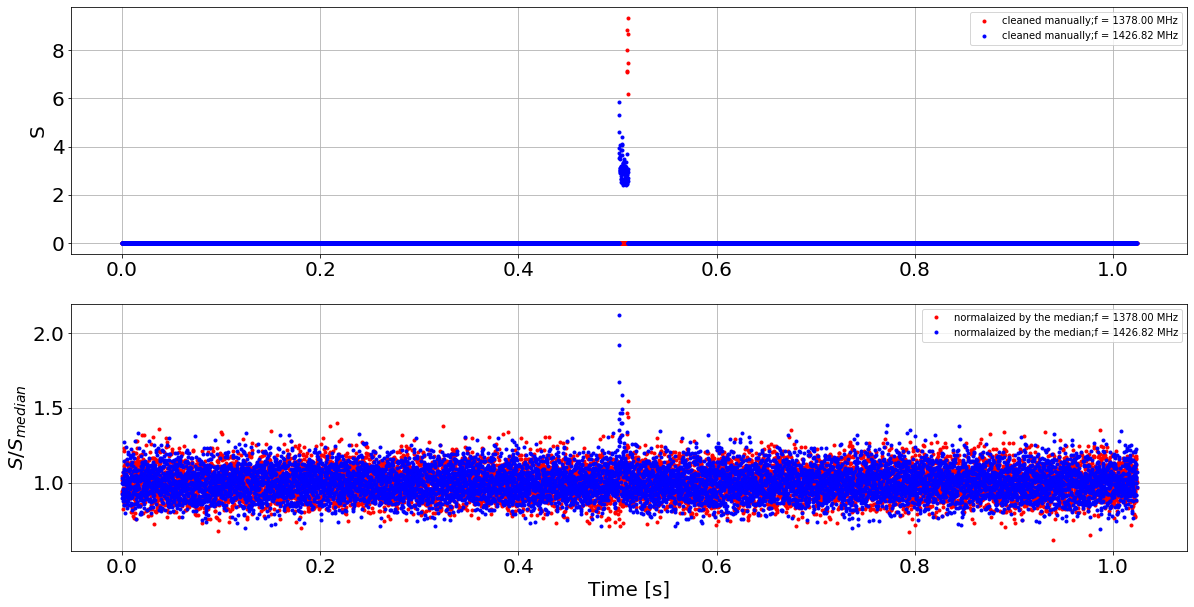

In [10]:
### EXTRA (not in the assignment): plotting the time-series of selection of channels for the two above cases

fig = figure(figsize=(20,10))
frame1 = fig.add_subplot(2,1,1)
frame2 = fig.add_subplot(2,1,2,sharex=frame1)


f1 = ds[250,:]
f2 = ds[350,:]
f3 = ds[450,:]

t1 = ds[:,2000]
t2 = ds[:,5000]
t3 = ds[:,8000]

imax = np.argmax(f1)

f1[:imax-4]=np.zeros_like(f1[:imax-4])
imax = np.argmax(f1)
f1[imax+4:]=np.zeros_like(f1[imax+4:])

imaxx = np.argmax(f2)
f2[:imaxx-4]=np.zeros_like(f2[:imaxx-4])
imaxx = np.argmax(f1)
f2[imaxx+4:]=np.zeros_like(f2[imaxx+4:])

frame1.plot(time,f1,".",color='red', label = "cleaned manually;f = {:.2f} MHz".format(f[250]))
frame1.plot(time,f2,".",color='blue', label = "cleaned manually;f = {:.2f} MHz".format(f[350]))

ds=np.load(path + 'B0355+54_dynamicspectrum.npy')
#print shape of dynamic spectrum
print("DS shape is: "+str(ds.shape))
ds =ds[::-1]  #flipping frequency axis

f1 = ds[250,:]
f2 = ds[350,:]
frame2.plot(time,f1/np.median(f1),".r", label='normalaized by the median;f = {:.2f} MHz'.format(f[250]))
frame2.plot(time,f2/np.median(f2), ".b", label='normalaized by the median;f = {:.2f} MHz'.format(f[350]))

#frame1.set_xlim(0.4,0.6)
frame1.set_ylabel("S",fontsize =20)
frame1.tick_params(axis='both', which='major', labelsize=20)

frame2.set_xlabel("Time [s]",fontsize =20)
frame2.set_ylabel(r"$S/S_{median}$",fontsize =20)
frame2.tick_params(axis='both', which='major', labelsize=20)

frame1.legend()
frame1.grid()

frame2.legend()
frame2.grid()
show()

#### The first panel portrays the strips that we see in the flux density map. Each frequency has discern value over time and varies around a certain value. In the second plot, you can see the difference between the flux density of each strip, which is not smooth at all. Therfore, we see islands of frequency bands in the imshow map. This is known as Radio Frequency Interference, these signals are usually originated from sources other than the pulsar. I used two different ways to deal with them: 1. I found the index corresponding to the maximum value and then zeroed the rest of the signal 2. I divided the signal flux density by its median at each channel, and since the noise have the same magnitude as you can see in the first panel of the above image, they would flatten and only the pulse would stick out

You can see an example of a bright single pulse from this pulsar.

Question 3: Why is the pulse "swept" across frequency? i.e. why do the higher frequencies arrive earlier than the lower frequencies? 

Problem 3: Determine the correct "Dispersion Measure" of this pulsar, with uncertainties, and correct the data for this frequency sweep. 

Problem/Question 3 is worth 2 points (0.5 for answering the question, 1 for finding the correct DM and uncertainty and 0.5 for correcting the data to the correct DM).

#### The reason that the pulse sweeps across the image is becuase of the dispersion effect, where the waves with higher frequencies are detected faster that the waves in lower frequencies $\Delta t \varpropto \frac{1}{\nu^2}$. This is due the traveling of the electromagentic wave in a medium (earth atmospher), so the group velocity: 

from the lecture notes, we know that:

$\Delta t=4.15 \times 10^6 \mathrm{~ms} \times \mathrm{DM} \times\left(\nu_{\text {low }}^{-2}-\nu_{\text {high }}^{-2}\right)$

if I calculate this roughly:

$42 ms = 4.15 \times 10^6 \times DM \times (1500^{-2} - 1300^{-2})$

In [11]:
dm = 42/(4.15e6*(f[0]**-2 - f[-1]**-2))

print('Dm is roughly {:.2f} pc/cc'.format(dm))

Dm is roughly 52.51 pc/cc


### First approach: rough estimation

#### so I use the $\Delta t$ delay to measure how much every frequency must shift to match the phase of the lowest frequency

In [12]:
time_corrected = np.zeros_like(ds)
def dedisperse(ds):
    '''This function takes the dynamic spectrum finds the maximum flux of each channel,
       calculates the time difference of the maximum of tha channel with the maximum of the lowest frequency
       and shifts the time by that amount. If the time of the maximum flux of a channel falls after the 
       time of the maximum flux of the lowest frequency, we would not shift the time of that channel'''
    n=0           
    for i in range(np.shape(ds)[0]):
        index = np.argmax(ds[i,:])
        t = time[index]
        index_final =np.argmax(ds[0,:])
        t_f = time[index_final]
        delta_t = t_f -t
        if delta_t>0:
            time_corrected[i,:] = time + delta_t
            
        else:
            time_corrected[i,:] = time
            n+=1
        
    return time_corrected,n
        
        
    
time_new,n =dedisperse(ds)

In [13]:
print("the number of channels that their maximum flux density does not indicate the pulse is {}".format(n)+
"\n so we would not shift them")

the number of channels that their maximum flux density does not indicate the pulse is 59
 so we would not shift them


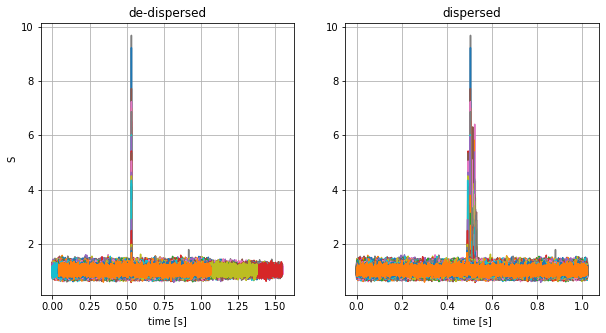

In [14]:
fig = figure(figsize = (10,5))

frame1 = fig.add_subplot(1,2,1)
frame2 = fig.add_subplot(1,2,2, sharey=frame1)

for i in range(np.shape(ds)[0]):
    frame1.plot(time_new[i,:],ds_normal[i,:])
    frame2.plot(time,ds_normal[i,:])

frame1.grid()
frame2.grid()

frame1.set_title("de-dispersed")
frame2.set_title("dispersed")

frame1.set_xlabel("time [s]")
frame2.set_xlabel("time [s]")

frame1.set_ylabel("S")
show()

In [15]:
#In this part we would like to build a new DS
#knowing the time delay we can shift the values
#for each channel, so the maxima would line up

index_max = np.argmax(ds_normal[0,:])
index_min = np.argmax(ds_normal[511,:])
delta_i = index_max - index_min

ds_new = np.zeros((np.shape(ds)[0],np.shape(ds)[1]+index_max-index_min))

for i in range(np.shape(ds)[0]):
        
    index = np.argmax(ds_normal[i,:])
    if index_max - index < delta_i and index_max - index>0:
        delta_index = index_max-index
   
        ds_new[i,:][delta_index:10000+delta_index]=ds_normal[i,:]
    else:
        ds_new[i,:][:10000]=ds_normal[i,:]
    


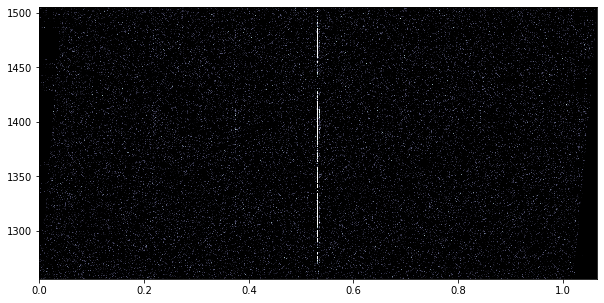

In [16]:
fig = figure(figsize=(10,5))
frame = fig.add_subplot(1,1,1)

im = frame.imshow(ds_new/ds.max(),aspect = 'auto', origin='lower', cmap='bone', extent = [0,time_new[-1][-1], f[0],f[-1]],vmin=0.01,vmax=0.015)

show()

#### in the above part, I have de-dispersed the data manually, and I moved it forward in time. However, in the next approach, which is more robust, I will use the best fit, and move the data backward.

### Second approach: Fitting 

In [17]:
ds=np.load(path + 'B0355+54_dynamicspectrum.npy')
#print shape of dynamic spectrum
ds =ds[::-1]  #flipping frequency axis

In [18]:
DM_i = np.arange(5,95,10)
print("These are our choices for the initial DM = ", DM_i)


def dt(ff,DM):
    '''calculates the time delay in ms'''
    f_low =f[0]
    f_high = f[-1]
    delta_t = 4.15e6*DM*(ff**-2 - f_high**-2)
    
    return delta_t/1000

These are our choices for the initial DM =  [ 5 15 25 35 45 55 65 75 85]


In [19]:
### building a time axis for each DM sample
### in this part we will take a look at the de-dispersion time series for each DM
### this helps us to find the proper range for DM, and have more accurate initial guess

time_dm1 = np.zeros_like(ds)
time_dm2 = np.zeros_like(ds)  
time_dm3 = np.zeros_like(ds)
time_dm4 = np.zeros_like(ds)  
time_dm5 = np.zeros_like(ds) 
time_dm6 = np.zeros_like(ds)
time_dm7 = np.zeros_like(ds)
time_dm8 = np.zeros_like(ds)
time_dm9 = np.zeros_like(ds)

TIME = [time_dm1,time_dm2,time_dm3,time_dm4,time_dm5,time_dm6,time_dm7,time_dm8,time_dm9]
for i in range(len(DM_i)):
    for j in range(len(f)):
        TIME[i][j,:]= time - dt(f[j],DM_i[i])

In [20]:
from tqdm import tqdm
import sys

Progress: 100.00%


label progress: 100%|██████████| 9/9 [00:00<00:00, 232.00it/s]


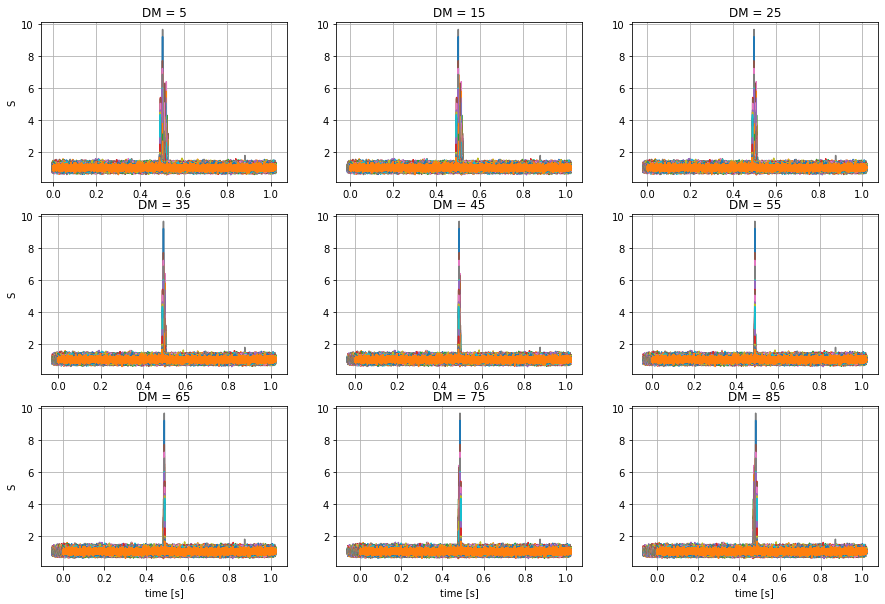

In [21]:
############ ALERT: THIS CELL IS VERY MEMORY DEMANDING #########
###### it is also independant cell, so it does not effect the rest of the assignment#####

fig = plt.figure(figsize=(15, 10))
nr=3
nc=3
frame1 = fig.add_subplot(nr, nc, 1)
frame2 = fig.add_subplot(nr, nc, 2, sharey=frame1)
frame3 = fig.add_subplot(nr, nc, 3, sharey=frame1)
frame4 = fig.add_subplot(nr, nc, 4)
frame5 = fig.add_subplot(nr, nc, 5)
frame6 = fig.add_subplot(nr, nc, 6)
frame7 = fig.add_subplot(nr, nc, 7)
frame8 = fig.add_subplot(nr, nc, 8)
frame9 = fig.add_subplot(nr, nc, 9)

FRAME = [frame1,frame2,frame3,frame4,frame5,frame6,frame7,frame8,frame9]


for i in range(np.shape(ds)[0]):
    for j in range(len(FRAME)):
        FRAME[j].plot(TIME[j][i, :], ds_normal[i, :])

    progress = (i + 1) / np.shape(ds)[0] * 100
    sys.stdout.write("\rProgress: {:.2f}%".format(progress))
    sys.stdout.flush()

sys.stdout.write("\n")

    
    
j=0
for j in tqdm (range(len(FRAME)), desc='label progress'):
    FRAME[j].grid()
    FRAME[j].set_title(r'DM = {}'.format(DM_i[j]))
    
    

frame7.set_xlabel("time [s]")
frame8.set_xlabel("time [s]")
frame9.set_xlabel("time [s]")

frame1.set_ylabel("S")
frame4.set_ylabel("S")
frame7.set_ylabel("S")


show()

#### by inspecting above plots for different DMs, we can easily see that DM must lie between 45 and 65, and a value around 55 seems a good fit, as I have calculated using the first approach. Now, we have to find the best DM that results in the least dispersion. So in the following I will use the 1000 samples for DM, equally spaced between 45 and 65. Then I will scan the each DS(dm) for each time along the frequency, and find the time bin with highest value. The DS(dm) that returns a time bin with highet value will have the least dispersion., beacause that mean the pulse has been aligned. 

In [22]:
import math

### in this part, we calculate the de-dispersed DS for 100 different DM
### form 56 to 58 range. This range has been refined after several try and trial
### I find the best fit based on the bin population, the larger the population the better is the fit

N=100
DM_sample = np.linspace(56,58,N)
BIN_STORE= np.zeros(N)
DELTA_T = np.zeros_like(DM_sample)
DM_good = []
diFF = []
print()
#for i in range(len(DM_sample)):


for count, dm in enumerate(DM_sample):
    DT_ref = dt(f[0],dm) 
    diff_ref=math.ceil(DT_ref/tsamp)
    DS_grand = np.pad(ds_normal,((0,0),(diff_ref,0)))             #create a pad to the left to move data backward
    
    for i in range(np.shape(ds_normal)[0]):
        delta_t = dt(f[i],dm)
        diff = math.ceil(delta_t/tsamp)
        diFF.append(diff_ref-diff)
        
        DS_grand[i,diff_ref-diff:10000+diff_ref-diff] = ds_normal[i,:]

    index_finder = np.zeros((1))
    ii=0
    jj=0
    while jj <np.shape(DS_grand)[1]:                            #finding the bin with most signal (indication of the pulse)
        if DS_grand[:,ii].sum()>DS_grand[:,jj].sum():
            index_finder = ii
            jj+=1
        else:
            ii=jj
            jj+=1
            
    BIN_STORE[count]=DS_grand[:,index_finder].sum()           #storing the bin-size
    progress = ((count + 1) / N)* 100
    sys.stdout.write("\rProgress: {:.2f}%".format(progress))
    sys.stdout.flush()       

sys.stdout.write("\n")



Progress: 100.00%


In [23]:
def gaussian(x,mu,sigma,amp,tail):
    '''Gaussian function to fit to the data.
       I added tail and amplitude to have more free params'''
    return amp*np.exp(-(x-mu)**2/(2*sigma**2)) + tail

def residual(param,x,y):
    '''Calculates the residula between the model and the data'''
    mu,sigma,amp,tail = param
    y_model = gaussian(x,mu,sigma,amp,tail)
    res = y - y_model
    return res
    

param_init = [DM_sample.mean(),DM_sample.std(),2*BIN_STORE.max(),BIN_STORE.min()]   #initial parameter

In [24]:
result = opt.least_squares(residual, param_init, args=(DM_sample, BIN_STORE))   #using least square for best fit
mu, sigma, amp,tail = result.x
y_model = gaussian(DM_sample,mu,sigma,amp,tail)


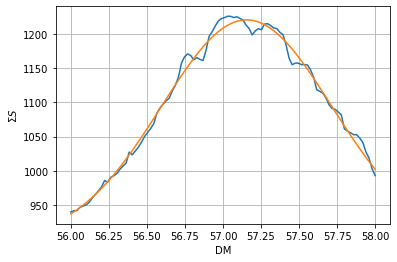

In [25]:
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(DM_sample,BIN_STORE,label= 'data')
frame.plot(DM_sample,y_model, label='fitted model')
frame.set_xlabel("DM")
frame.set_ylabel(r"$\Sigma S$")
frame.grid()

show()

In [34]:
print('The best fit is derived for the DM ={:.2f}'.format(mu) + '±{:.2f} pc/cc'.format(sigma))
chi = chisquare(BIN_STORE, f_exp=y_model, ddof=len(DM_sample)-3, axis=0)
print("the relatively small chi-statistic {:.2f} shows that this fit is a good fit".format(chi[0]))

The best fit is derived for the DM =57.16±0.56 pc/cc
the relatively small chi-statistic 6.72 shows that this fit is a good fit


In [35]:
### we are going to use the best fit DM to reorganize the DS

DT_ref_best = dt(f[0],mu) 
diff_ref_best=math.ceil(DT_ref_best/tsamp)

DS_DD = np.pad(ds_normal,((0,0),(diff_ref_best,0))) #storage for the de-dispersed DS with zero pad on the left-side

for i in range(np.shape(DS_DD)[0]):
    ind_diff = math.ceil(dt(f[i],mu)/tsamp)
    DS_DD[i,diff_ref_best-ind_diff:np.shape(ds_normal)[1]+diff_ref_best-ind_diff] = ds_normal[i,:]

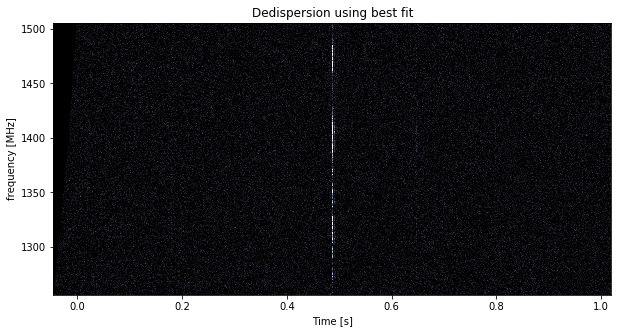

In [37]:
fig = figure(figsize=(10,5))
frame = fig.add_subplot(1,1,1)

DS_DD_NORM = DS_DD/DS_DD.max()
im = frame.imshow(DS_DD_NORM,aspect = 'auto', origin='lower', cmap='bone', extent = [0-dt(f[0],mu),time_new[-1][-1]-dt(f[0],dm), f[0],f[-1]],vmin=0.10,vmax=0.25)
frame.set_title("Dedispersion using best fit")
frame.set_xlabel("Time [s]")
frame.set_ylabel("frequency [MHz]")
show()

Now that we have corrected for dispersion, plot the time series of the data (i.e. the dynamic spectrum scrunched in frequency).

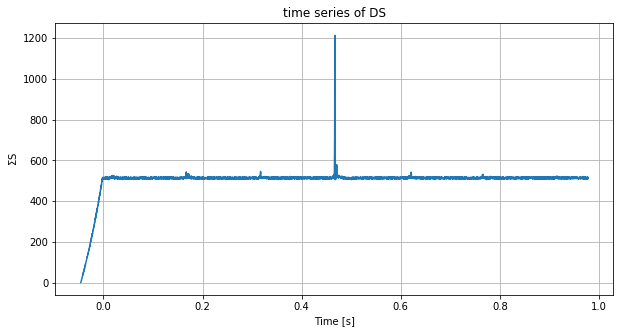

In [38]:
ds_time = [sum(row) for row in zip(*DS_DD)]
time = np.linspace(-dt(f[0],mu),time[-1]-dt(f[0],mu),np.shape(DS_DD)[1])
fig = figure(figsize=(10,5))
frame = fig.add_subplot(1,1,1)
frame.plot(time,ds_time)
frame.set_title("time series of DS")
frame.set_ylabel(r"$\Sigma$S")
frame.set_xlabel("Time [s]")
frame.grid()
show()

#### In the above plot, we have appointed the highest frequency as a refrence point and shifted the whol3 DS w.r.t that frequency, so basically going backward in time, that is why we can see part of the data descending in the negative time. I did this becuase in the next part, the de-dispersion is also done backward. In order to show that it is possible to go forward in time (which is more plausible in my mind, since you don't need to snip data for negative time), I used it for the first approach, as I plotted it earlier before this section.

To keep the file sizes low, the dynamic spectrum is a really short amount of time, meaning the average profile will not have stabilised. Therefore at this step we read in the file "B0355+54_fullprof.npy", which contains the time series of a longer chunk of time from this observation (dedispersion and frequency scrunching has already been applied). So instead of using the time series you plotted from the dynamic spectrum, we will use this longer time series for the remaining analyses.

Work out the duration of this longer time series. Note: the sampling time is the same as the original dynamic spectrum from above. You will also need to make a new time axis for this longer time series. 

This pulsar is bright enough that we can see many single pulses by eye already in the time series. Most pulsars can only be seen after folding the data using the period of the pulsar. 

Problem 4: Plot the power spectrum and determine the period of this pulsar. 

Note: also you'll only want to plot the power spectrum between ~1 - 50 Hz, but you can also investigate a broader spectral range if you like. Note you might want to remove the first 1000 bins of the power spectrum which contains some large spikes which reduces the visibility of structure in the rest of the power spectrum.

Question 4: Why are there multiple peaks on the power spectrum, and how can you use these to better constrain the rotational period? 

(2 points for Problem/Question 4)

In [39]:
full_profile = np.load(path+'B0355+54_fullprof.npy')


new_time = np.zeros(len(full_profile))
for i in range(len(full_profile)-1):
    new_time[i+1] = new_time[i]+tsamp

In [40]:
from scipy.signal import find_peaks
from scipy import fft

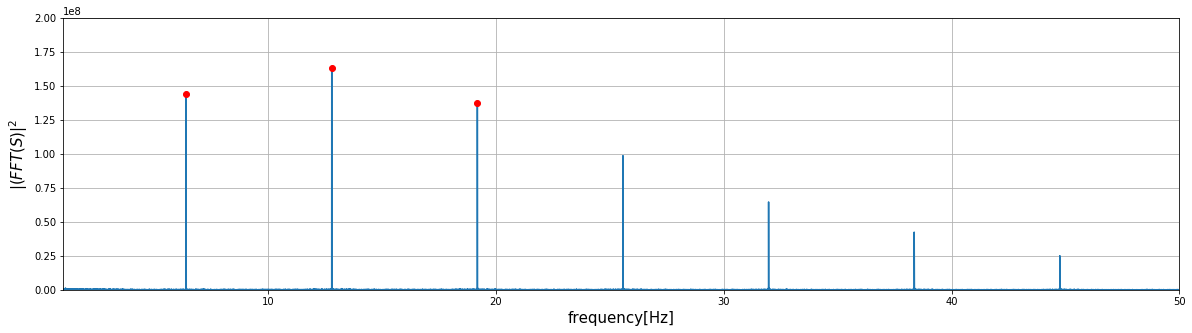

In [41]:
fig = figure(figsize=(20,5))
frame=fig.add_subplot(1,1,1)
low=0
high=len(full_profile)
ps = (np.abs(fft(full_profile)))**2


ps_slice = ps
time_slice = new_time
frequency = np.fft.fftfreq(len(ps_slice),d=tsamp)

frame.plot(frequency,ps_slice)
#frame.axvline(x=time[index_t],color='red',ls='--',lw=1)
peaks_index = find_peaks(ps_slice, threshold=1e8)[0]
pos_i=[]
for j in peaks_index:                        #filter the negative frequencies
    if frequency[j]>0:
        pos_i.append(j)
        
#print(pos_i)
france = frequency[pos_i]
frame.plot(frequency[pos_i], ps_slice[pos_i],'or')
frame.set_xlim(xmin=1,xmax=50)
frame.set_ylim(ymin=0,ymax=2e8)
frame.set_xlabel("frequency[Hz]", fontsize=15)
frame.set_ylabel(r"|$(FFT(S)$|$^2$", fontsize =15)
frame.grid()
show()

#### I calcualted the power spectrum and found the peaks with a certain threshhold. choosing the threshhold is a tricky business, we can take the threshold high, and we will get a few peaks (six or seven) but in this case, we will miss a lot of pulse. I decided to keep the threshold lower, so I included more pulses but that also mean to invite unrelated peaks. So in order to address this problem, I look at the histogram of the derived periods. Find the bin that I am suspecting to be related to the pulsar's period, and take the average of that bin. I believe this is more inclusive that setting a high threshold.

#### UPDATE: since I needed to get an exact period, I considered only three pulses. so the bin has only two values. The more accurate approach in my opinion is to lower the threshold to include as many pulses as possible along various frequencies, and use the histogram to fin the ones that have similiar period but this has cuased some inaccuracies later in the JOY divison. So, I decided to stick to three pulses that produce the exact same period.

#### the reason that there is multiple peaks is that we recieve the pulses in different frequencies (different sinusoidal waves) with different amplitude, so we have different peaks in various frequencies. 

In [42]:
def peaky(peaks_index,f):
    '''This function finds the time period taking the frequencies
       and thier pulse-related indiecies'''
    period = []
    for i in range(0,len(peaks_index)-1):
        period.append(1/(f[peaks_index[i+1]]- f[peaks_index[i]]))
        
    return period

def pp(period):
    '''Takes all the time intervals and finds the most populated bin,
       and takes the average of the bin edges'''
    hist_counts, bin_edges = np.histogram(period, bins=30)
    
    

    max_i = np.argmax(hist_counts)
    max_bin1 =bin_edges[max_i] 
    max_bin2 = bin_edges[max_i+1]

    period_avg = (max_bin1+max_bin2)/2
    vals = []
    for i in period:
        if i>=max_bin1 and i<=max_bin2:
            vals.append(i)
    period_mean = np.mean(vals[:6])
    sigma = np.std(vals[:6])/6**0.5
    
    return period_avg,period_mean,sigma, hist_counts[max_i]
    


In [43]:
PERIOD = peaky(pos_i,frequency)
p = np.asarray(PERIOD)
pulsar_period = pp(PERIOD)
print("the bin-average period of this pulsar is {} [s]".format(pulsar_period[0]))
print("the mean period of this pulsar is {} [s]".format(pulsar_period[1]))
print("the standard deviation on the mean period is {}".format(pulsar_period[2]))


the bin-average period of this pulsar is 0.17307104851330207 [s]
the mean period of this pulsar is 0.1564043818466354 [s]
the standard deviation on the mean period is 0.0


#### The difference between mean and average here is that in the first case, i take the average of the bin edges, and in the second case I take the average of the bin values, which I also calculate the std on the mean. In the above plot, we can see the population of the pulsars (considering the power threshold) in the last bin

Problem 5: Fold the data using this period. (1 point)

Problem 6: Plot the signal strength versus pulse number (time) and rotational phase. Think "Joy Division" pulsar plot. (2 points)

Note: for Problem 6 it will be useful to calculate how many rotations you expect in this observation duration. For plotting choose a reasonable number to show (hint: there are too many pulses in this observation to show in one plot), and zoom in in phase to make the pulses clearer visually. It might also be nice to plot the profile and by eye decide which subset of pulses to show (e.g. the brightest ones).

Question 5: is it surprising that the pulses aren't all of the same intensity?  Pulsars have stable pulse profiles, which are the basis for doing precision pulsar timing, right?  So how can that work if each pulse is different?  Discuss... (BONUS 1 point)

Problem 7: Plot the average pulse profile. On the same plot, show the published average profile "model" and compare the two profiles. (1 point)

Note: You'll likely have to normalise the profile and move the peak to the centre of the phase window in order to best compare the two. Make sure you label the lines in the plot. 

In [44]:
from scipy import interpolate

In [46]:
full_profile = np.load(path +'B0355+54_fullprof.npy')
full_profile = full_profile[1000:]                #begin further to position the profile in the middle
tsamp = 0.00010240000000000002
pulp=pulsar_period[1] + pulsar_period[2]            #the mean period calculated by me with its std

new_time = np.zeros(len(full_profile))              
delta_t = pulp/math.ceil(pulp/tsamp)

for i in range(len(full_profile)-1):
    new_time[i+1] = new_time[i]+ tsamp
    
inter_time = np.zeros_like(new_time)


for i in range(len(inter_time)-1):
    inter_time[i+1] = inter_time[i] + delta_t

func = interpolate.interp1d(new_time,full_profile)

inter_profile = func(inter_time)


In [47]:
print("new time has length the {}".format(len(new_time)))
print('the begining of the time is {} and the end-time is {:.3f}'.format(new_time[0],new_time[-1]))
print("the size of the bin for 1 pulse is {:.3f}".format(pulsar_period[1]/tsamp))
print("we expect {:.3f} pulses in the new time".format(len(new_time)/(pulsar_period[0]/tsamp)))

new time has length the 2927000
the begining of the time is 0.0 and the end-time is 299.725
the size of the bin for 1 pulse is 1527.387
we expect 1731.802 pulses in the new time


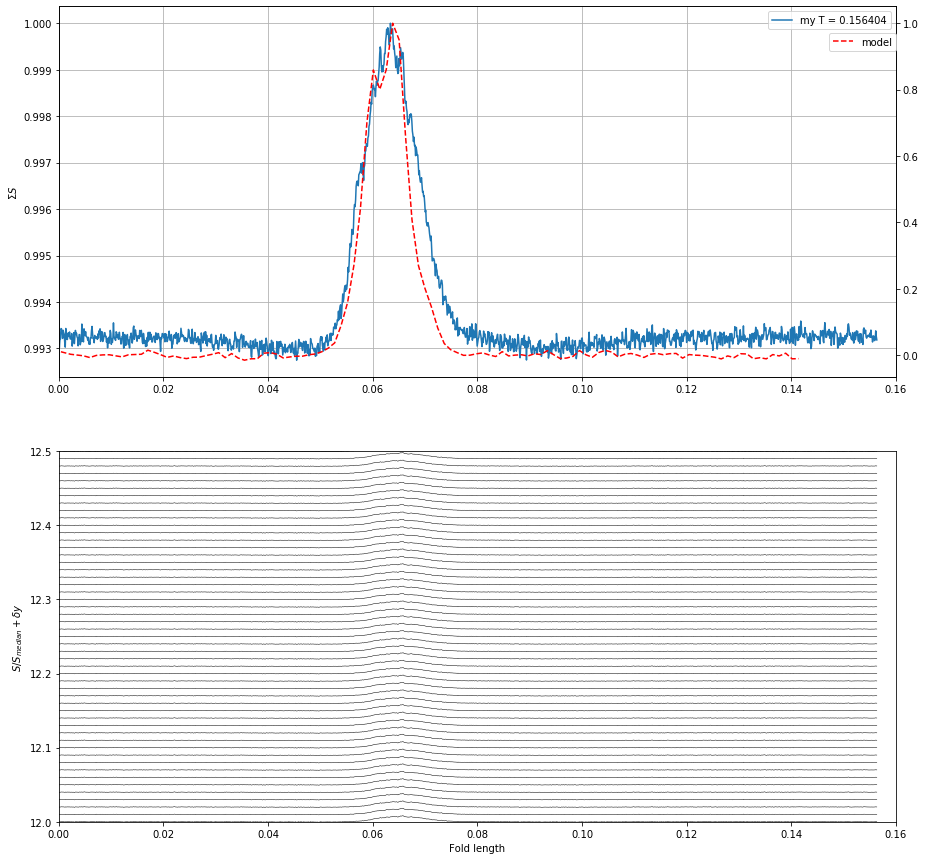

In [53]:
fig = figure(figsize = (15,15))
frame2 = fig.add_subplot(2,1,1)
frame1 = fig.add_subplot(2,1,2)

tw1 = frame2.twinx()
RANGE = math.ceil(len(new_time)/(pulp/delta_t))
pulse = math.ceil(pulp/delta_t)
ROY =np.zeros(pulse)
JOY = np.zeros_like(ROY)
model=np.loadtxt(path+'/antt94_1330.txt')[:,3]

for i in range(RANGE):
    ROY = inter_profile[i*pulse:(i+1)*pulse]
    if len(ROY)==len(JOY):
        JOY += ROY
    
        frame1.plot(new_time[:pulse],i/100+ JOY/np.median(JOY), color='black', lw =0.5)
    else:
        break
        
    
    
time_model = np.linspace(new_time[0],new_time[0]+pulsar_period[1],len(model)) - 0.015
frame2.plot(new_time[:pulse],JOY/JOY.max(), label = 'my T = {:.6f}'.format(pulsar_period[1]))
tw1.plot(time_model,model/model.max(),color='red',ls='--',label='model')
frame2.set_xlim(0,0.16)
frame1.set_xlim(0,0.16)

frame1.set_ylim(12,12.5)


frame2.legend()
frame2.grid()


tw1.legend(loc=(0.92,0.88))
frame1.set_xlabel("Fold length")
frame1.set_ylabel(r"$S/S_{median} + \delta y $")
frame2.set_ylabel(r"$\Sigma{S}$")

show()

#### In the above part, I plotted the joy division for two different periods: my period, and the one Iris provided. Unfotunately, my period is not as accurate and it results in a propogating offset, which misaligns the phases of the pulses. Hence, I used the period calculated by Iris and folded the profile, which is displayed on the right hand subplot; in this case, the period is more accurate, therefore the phases are aligned.

#### Is it surprising that the pulses have different intensity? no, becuase the pulses that we recieve have different wave frequencies, as was shown in the power spectrum. So they interact differently to the meduim along the line-of-sight. For example, the atmosphere is more opaque to higher frequencies that the lower ones, that's why we have less intense pulses in higher frequencies.

Finally, 

Problem 8: using the average profile, measure the approximate width of the profile and compare with the pulse period (1 point). 

#### In order to find the width, I will fit a gaussian function on the average profile and find the FWHM of the model. 

In [54]:
imax = np.argmax(JOY)

In [55]:
par_i = [new_time[:pulse][imax],0.05,1,0.993]   #initial parameter

In [70]:
result_f = opt.least_squares(residual, par_i, args=(new_time[:pulse], JOY/JOY.max()))   #using least square for best fit
mu_f, sigma_f, amp_f,tail_f = result_f.x
y_model_f = gaussian(new_time[:pulse],mu_f,sigma_f,amp_f,tail_f)

FWHM = 2*sigma_f*(2*np.log(2))**0.5

DUTY = FWHM/pulsar_period[1]

print('the duty of this pulsar is about {:.2f} %'.format(DUTY*100))


the duty of this pulsar is about 7.52 %


In [64]:
x1 = mu_f-FWHM/2
x2 = mu_f + FWHM/2

y1 = gaussian(x1,mu_f,sigma_f,amp_f,tail_f)
y2 = gaussian(x2,mu_f,sigma_f,amp_f,tail_f)

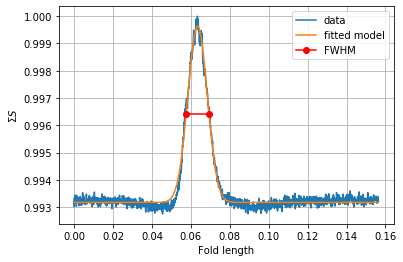

In [68]:
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(new_time[:pulse],JOY/JOY.max(),label= 'data')
frame.plot(new_time[:pulse],y_model_f, label='fitted model')
frame.plot((x1,x2),(y1,y2),"o-", color='red',label ='FWHM')
frame.set_xlabel("Fold length")
frame.set_ylabel(r"$\Sigma S$")
frame.grid()
frame.legend()
show()

##### the ratio that we have derived earlier is the duty cycle of the pulsar and can help us to shed some light about the emission form this pulsar, and the regions that radiate, if they are relatively large the FWHM can also be larger. Also the line broadening due to ISM can also have affects on this ratio. In our case, we only 7.5 % of the period is in FWHM which means that emitting region is probably smaller compared to the pulsars with the same period but larger FWHM. 